# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

In this project, I try to understand the results of an A/B test run by an e-commerce website.  The main goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#setting the seed so that results can be reproduced
random.seed(42)

Importing the dataset

In [2]:
df = pd.read_csv('ab_data.csv')

Exploring dataset at a basic level

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [6]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Further analysing the dataset

The number of unique users in the dataset.

In [7]:
df['user_id'].nunique()

290584

The proportion of users converted.

In [8]:
df['converted'].mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't line up.

In [9]:
df.query(('group == "treatment" & landing_page == "old_page"')).shape[0] + df.query(('group == "control" & landing_page == "new_page"')).shape[0]

3893

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page. Hence dropping those rows.

In [10]:
df2 = df[(df.group == 'treatment') & (df.landing_page == 'new_page')].append(df[(df.group == 'control') & (df.landing_page == 'old_page')])

Verifying dropped rows

In [11]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

unique **user_id**s are in **df2**

In [12]:
df2['user_id'].nunique()

290584

Removing duplicates

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [15]:
df2.drop_duplicates(['user_id'], keep='first', inplace=True)

In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [17]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


The probability of an individual converting regardless of the page they receive?

In [18]:
df2['converted'].mean()

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
df2[df2['group'] == 'control']['converted'].mean()

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
df2[df2['group'] == 'treatment']['converted'].mean()

0.11880806551510564

In [21]:
obs_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
obs_diff

-0.0015782389853555567

What is the probability that an individual received the new page?

In [22]:
df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

50% of the individuals received the new page and the other 50% received the old page suggesting that the treatment and control group were properly divided. 
The conversion ratio in the control group is around 12.04% and that of treatment group is 11.88%

Statistical evidence suggests that, from the given data, the old page received by the control group has more conversion rate than the new page received by the treatment group. But the difference in convesion rate is practically not significant to conclude that one page produces better conversion than the other.

<a id='ab_test'></a>
### Part II - A/B Test

Forming Null(**$H_{0}$**) and Alternate(**$H_{1}$**) Hypothesis

(**$H_{0}$**) : **$p_{old}$** >= **$p_{new}$**

(**$H_{1}$**) : **$p_{old}$** < **$p_{new}$**

**Convert rate** for $p_{new}$ under the null? 

In [23]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**Convert rate** for $p_{old}$ under the null? <br>

In [24]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

$n_{new}$?

In [25]:
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]
n_new

145310

$n_{old}$?

In [26]:
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null and Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.binomial(1, p_new, n_new)

In [28]:
new_page_converted.mean()

0.12045282499483861

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null and Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [29]:
old_page_converted = np.random.binomial(1, p_old, n_old)

In [30]:
old_page_converted.mean()

0.1202210994396795

$p_{new}$ - $p_{old}$ for the simulated values

In [31]:
new_page_converted.mean() - old_page_converted.mean()

0.00023172555515911519

Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process and Storing all 10,000 values in **p_diffs**.

In [32]:
p_diffs = []
size = df2.shape[0]
for i in range(10000):
    new_page_converted1 = np.random.binomial(1, p_new, n_new)
    old_page_converted1 = np.random.binomial(1, p_old, n_old)
    p_new1 = new_page_converted1.mean()
    p_old1 = old_page_converted1.mean()
    p_diffs.append(p_new1-p_old1)

Plotting a histogram of the **p_diffs**

(array([  6.10000000e+01,   3.79000000e+02,   1.33800000e+03,
          2.63500000e+03,   2.94500000e+03,   1.84300000e+03,
          6.58000000e+02,   1.24000000e+02,   1.50000000e+01,
          2.00000000e+00]),
 array([-0.00394587, -0.00300431, -0.00206276, -0.00112121, -0.00017965,
         0.0007619 ,  0.00170345,  0.00264501,  0.00358656,  0.00452811,
         0.00546967]),
 <a list of 10 Patch objects>)

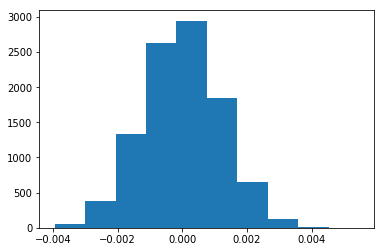

In [33]:
plt.hist(p_diffs)

Proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**

In [34]:
(p_diffs > obs_diff).mean()

0.90529999999999999

The value of 0.905 calculated above is the 'p value' of the A/B test conducted. With a Type I error rate of 0.05%, and p value as 0.905, we have statistical evidence to conclude the we fail to reject the null hypothesis that the new page is no better in conversion than the old page.

**Hence practically, the new page does not produce better conversions than the old page**

Using built-in method to achieve the same result

In [35]:
import statsmodels.api as sm

convert_old = df2[df2['group'] == 'control'].query('converted == 1').shape[0]
convert_new = df2[df2['group'] == 'treatment'].query('converted == 1').shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [36]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

In [37]:
p_value

0.90505831275902449

In [38]:
z_score

1.3109241984234394

In [39]:
from scipy.stats import norm

In [40]:
norm.cdf(z_score)

0.90505831275902449

In [41]:
norm.ppf(1-(0.05/2))

1.959963984540054

A p_value of 0.905 is very much greater than the Type I error rate of 0.05, Suggesting we have statistical evidence to conclude that we fail to reject the null hypothesis that the old_page gets better or equal conversion rate than the new page.

A z score of 1.3116075339133115 is less than the critical value of 1.959963984540054 at 95% confidence. Hence we fail to reject the null hypothesis that the old_page gets better or equal conversion rate than the new page.

The results from the built in method agress with the previously calculated results.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see try to achieve the same result by performing Logistic regression.<br><br>

The goal is to use **statsmodels** to fit a Logistic regression model to see if there is a significant difference in conversion based on which page a customer receives.  For this, We first need to create a column for the intercept, and create a dummy variable column for which page each user received.

Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [42]:
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

In [43]:
df2['intercept'] = 1

In [44]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


In [45]:
df2.drop(['old_page'], axis=1, inplace=True)

In [46]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


Importing **statsmodels**

In [47]:
import statsmodels.api as sm

Instantiating the model

In [48]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

Fitting the model using the two columns we created above to predict whether or not an individual converts.

In [49]:
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 16 Jan 2019   Pseudo R-squ.:               8.077e-06
Time:                        15:52:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p value associated with the regression model is 0.190. The difference in p value between regression and A/B test is due to fact the the null and alternate hypothesis are different in case of regresion model when compared to the A/B test. 

A p value of 0.190 for ab_page suggests that the field does not have a statistically significant effect in predicting the conversion rate.

### **A/B Test:**

(**$H_{0}$**) : The new page is no better than the old page in terms of convertion rate or the old_page gets better or equal conversion rate than the new page.

(**$H_{1}$**) : The new page has a better conversion rate than the old page

### **Regression Model:**

(**$H_{0}$**) : The Independent variables have no signifiance in predicting the dependent variables.

(**$H_{1}$**) : The Independent variables have a significant role to play in predicting the dependent variables.

Considering other factors which have a significant effect in predicting the dependent variable would increase the accuracy of prediction. 
When additional factors are considered, in some cases it might produce problems such as multi collinearity , non linearity etc depending on the variables and the purpose for which the model is used for.

Adding an effect of country a user lives.

In [51]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [52]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
user_id    290584 non-null int64
country    290584 non-null object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


In [53]:
df2.shape

(290584, 7)

In [54]:
df_new = pd.merge(df2,df_country,on='user_id')

In [55]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [56]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

Creating dummy variables for countries

In [57]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [58]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [59]:
df_new.drop(['CA'], axis=1, inplace=True)

In [60]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,0,0


In [61]:
df_new['intercept'] = 1

In [62]:
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [63]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 16 Jan 2019   Pseudo R-squ.:               2.323e-05
Time:                        15:52:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

The countries with p values greater than the Type I error rate of 0.05 suggest that we have statistical evidence to conclude that we fail to reject the null hypothesis of countries not having an impact in predicting the conversion rate

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [64]:
df_new['page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['page_US'] = df_new['ab_page'] * df_new['US']

In [65]:
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,page_UK,page_US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,0,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,1,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,0,0,0,0


In [66]:
logit_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US','page_UK', 'page_US']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [67]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 16 Jan 2019   Pseudo R-squ.:               3.482e-05
Time:                        15:52:07   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
page_UK        0.0783      0.057      1.378      0.168      -0.033       0.190
page_US        0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

The page_country intercations with p values greater than the Type I error rate of 0.05 suggest that we have statistical evidence to conclude that we fail to reject the null hypothesis of page_country intercations not having an impact in predicting the conversion rate

In [68]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0